3 Epochluk eğitim. Doğru tensor kullanımı

In [ ]:
import os
import gc
import random
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from datasets import load_dataset
from google.colab import drive
from safetensors.torch import load_file

In [ ]:
drive.mount('/content/drive')
PROJE_PATH = "/content/drive/MyDrive/Contrastive_Ensembles_Proje_Final"
os.makedirs(PROJE_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MODEL_NAME = "ytu-ce-cosmos/turkish-e5-large"
BATCH_SIZE = 4
NUM_EPOCHS = 3
SUBSET_SIZE = 2500
SEEDS = [42, 123, 999]

In [ ]:
print(" Veri Seti indiriliyor: boun-tabilab/TQuad-2 ...")
try:
    dataset = load_dataset("boun-tabilab/TQuad-2", split="train")
except Exception as e:
    print(f"Hata: {e}...")

train_examples = []
task_instruct = 'Verilen Türkçe arama sorgusu ile ilgili pasajları getir.'

 Veri Seti indiriliyor: boun-tabilab/TQuad-2 ...


In [ ]:
print("Veri hazırlanıyor...")
all_contexts = [row['context'] for row in dataset]

counter = 0
for row in dataset:
    if counter >= SUBSET_SIZE:
        break

    q = row['question']
    p = row['context']

    if not q or not p or len(str(q)) < 5 or len(str(p)) < 20:
        continue

    # Hard Negative Mining (Random)
    while True:
        n = random.choice(all_contexts)
        if n != p:
            break

    query_text = f"Instruct: {task_instruct}\nQuery: {q}"
    train_examples.append(InputExample(texts=[query_text, p, n]))
    counter += 1

print(f" Toplam Eğitim Verisi: {len(train_examples)}")

Veri hazırlanıyor...
 Toplam Eğitim Verisi: 2500


**Eğitim Döngüsü**

In [ ]:
model_paths = []

for i, seed in enumerate(SEEDS):
    print(f"\n Training Model {i+1}/{len(SEEDS)} (Seed: {seed})...")

    save_path = f"{PROJE_PATH}/model_seed_{seed}"
    model_paths.append(save_path)

    # Bellek Temizliği
    if 'model' in locals(): del model
    torch.cuda.empty_cache()
    gc.collect()

    model = SentenceTransformer(MODEL_NAME, device='cuda')

    generator = torch.Generator()
    generator.manual_seed(seed)
    train_dataloader = DataLoader(train_examples, shuffle=True, generator=generator, batch_size=BATCH_SIZE)
    train_loss = losses.MultipleNegativesRankingLoss(model=model)

    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=NUM_EPOCHS,
        warmup_steps=int(len(train_dataloader) * 0.1),
        output_path=save_path,
        optimizer_params={'lr': 2e-5},
        use_amp=True,
        show_progress_bar=True
    )
    print(f" Model {i+1} kaydedildi: {save_path}")

print(f"\n Modeller Birleştiriliyor (SafeTensors Modu)...")

def load_weights(path):
    st_path = os.path.join(path, "model.safetensors")
    bin_path = os.path.join(path, "pytorch_model.bin")

    if os.path.exists(st_path):
        return load_file(st_path)
    elif os.path.exists(bin_path):
        return torch.load(bin_path, map_location='cpu')
    else:
        raise FileNotFoundError(f"Model ağırlıkları bulunamadı: {path}")

# İlk modeli referans al
merged_state_dict = load_weights(model_paths[0])

# Diğerlerini topla
for path in model_paths[1:]:
    state_dict = load_weights(path)
    for key in merged_state_dict:
        # Float32'ye çevirip topla (Hassasiyet kaybı olmasın)
        merged_state_dict[key] = merged_state_dict[key].float() + state_dict[key].float()

# Ortalamayı al
for key in merged_state_dict:
    merged_state_dict[key] = merged_state_dict[key] / len(model_paths)

FINAL_MODEL = f"{PROJE_PATH}/cosmos_merged_final"
print(" Final model diske yazılıyor...")

# Modeli kaydet
final_model = SentenceTransformer(MODEL_NAME)
final_model[0].auto_model.load_state_dict(merged_state_dict, strict=False)
final_model.save(FINAL_MODEL, safe_serialization=True)

print(f"\n Final model başarıyla kaydedildi: {FINAL_MODEL}")


 Training Model 1/3 (Seed: 42)...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.166100
1000,0.067600
1500,0.036000


 Model 1 kaydedildi: /content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/model_seed_42

 Training Model 2/3 (Seed: 123)...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.154300
1000,0.085400
1500,0.046100


 Model 2 kaydedildi: /content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/model_seed_123

 Training Model 3/3 (Seed: 999)...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.145900
1000,0.065500
1500,0.037400


 Model 3 kaydedildi: /content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/model_seed_999

 Modeller Birleştiriliyor (SafeTensors Modu)...
 Final model diske yazılıyor...

 Final model başarıyla kaydedildi: /content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/cosmos_merged_final


**PERFORMANS-TEST KISMI:**

In [ ]:
import os, gc, torch
from sentence_transformers import SentenceTransformer, evaluation
from datasets import load_dataset
from google.colab import drive

drive.mount('/content/drive')

PROJE_PATH = "/content/drive/MyDrive/Contrastive_Ensembles_Proje_Final"

models_to_test = {
    "Model 1 (Seed 42)": f"{PROJE_PATH}/model_seed_42",
    "Model 2 (Seed 123)": f"{PROJE_PATH}/model_seed_123",
    "Model 3 (Seed 999)": f"{PROJE_PATH}/model_seed_999",
    " MERGED ENSEMBLE": f"{PROJE_PATH}/cosmos_merged_final"
}

# -------------------------
# Test set (>=500 soru)
# -------------------------
print(" Test verisi (TQuad-2 Validation) indiriliyor...")
test_dataset = load_dataset("boun-tabilab/TQuad-2", split="validation")

test_dataset = test_dataset.select(range(min(500, len(test_dataset))))
print(f" {len(test_dataset)} adet test sorusu hazırlanıyor...")

queries, corpus, relevant_docs = {}, {}, {}
task_instruct = "Verilen Türkçe arama sorgusu ile ilgili pasajları getir."

for i, row in enumerate(test_dataset):
    q_id = str(row.get("id", i))
    doc_id = f"{q_id}_doc"

    query_text = f"Instruct: {task_instruct}\nQuery: {row['question']}"
    queries[q_id] = query_text
    corpus[doc_id] = row["context"]
    relevant_docs[q_id] = {doc_id}

evaluator = evaluation.InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name="TQuad_Test",
    show_progress_bar=True,
    mrr_at_k=[10],
    accuracy_at_k=[1, 5],
    batch_size=16
)

# -------------------------
# Helper: skor çekme
# -------------------------
def pick_score(scores: dict, suffix: str):
    # örn suffix="mrr@10" -> "TQuad_Test_mrr@10" veya direkt "mrr@10"
    for k, v in scores.items():
        if k.endswith(suffix):
            return float(v)
    return None

print(f"\n KARŞILAŞTIRMA ({len(models_to_test)} model)\n")
print(f"{'MODEL ADI':<25} | {'MRR@10':<10} | {'Acc@1':<10} | {'Acc@5':<10}")
print("-" * 65)

results_store = {}

for model_name, model_path in models_to_test.items():
    torch.cuda.empty_cache()
    gc.collect()

    try:
        print(f" Loading: {model_name} ...")
        model = SentenceTransformer(model_path, device="cuda")  # <-- EN KRİTİK SATIR

        scores = evaluator(model)  # <-- evaluator böyle çağrılır

        mrr10 = pick_score(scores, "mrr@10")
        acc1  = pick_score(scores, "accuracy@1")
        acc5  = pick_score(scores, "accuracy@5")

        print(f"{model_name:<25} | {mrr10:.4f}     | {acc1:.4f}     | {acc5:.4f}")
        results_store[model_name] = mrr10

        del model
        torch.cuda.empty_cache()

    except Exception as e:
        print(f" {model_name} HATASI: {e}")
        if "model" in locals():
            del model
        torch.cuda.empty_cache()

print("-" * 65)

if results_store:
    best_model = max(results_store, key=results_store.get)
    print(f"\n🥇 KAZANAN MODEL: {best_model} (MRR@10={results_store[best_model]:.4f})")

    merged_score = results_store.get("🚀 MERGED ENSEMBLE", 0.0)
    seeds = [results_store.get("Model 1 (Seed 42)", 0.0),
             results_store.get("Model 2 (Seed 123)", 0.0),
             results_store.get("Model 3 (Seed 999)", 0.0)]
    seeds_avg = sum(seeds) / 3

    print("\n📝 RAPOR NOTU:")
    if merged_score >= seeds_avg:
        print("Ensemble (merged) ortalama tekil performansın üstünde/eşit: iyi bir kararlılık ve genelleme sinyali.")
    else:
        print("Merged düşük.")
else:
    print("\n Test tamamlanamadı.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📥 Test verisi (TQuad-2 Validation) indiriliyor...
✅ 500 adet test sorusu hazırlanıyor...

🏆 KARŞILAŞTIRMA (4 model)

MODEL ADI                 | MRR@10     | Acc@1      | Acc@5     
-----------------------------------------------------------------
🔹 Loading: Model 1 (Seed 42) ...


The tokenizer you are loading from '/content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/model_seed_42' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:29<00:00, 29.02s/it]


Model 1 (Seed 42)         | 0.7043     | 0.5700     | 0.8760
🔹 Loading: Model 2 (Seed 123) ...


The tokenizer you are loading from '/content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/model_seed_123' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it]


Model 2 (Seed 123)        | 0.7089     | 0.5760     | 0.8800
🔹 Loading: Model 3 (Seed 999) ...


The tokenizer you are loading from '/content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/model_seed_999' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:28<00:00, 28.52s/it]


Model 3 (Seed 999)        | 0.6980     | 0.5680     | 0.8720
🔹 Loading: 🚀 MERGED ENSEMBLE ...


The tokenizer you are loading from '/content/drive/MyDrive/Contrastive_Ensembles_Proje_Final/cosmos_merged_final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:28<00:00, 28.61s/it]

🚀 MERGED ENSEMBLE         | 0.7162     | 0.5860     | 0.8880
-----------------------------------------------------------------

🥇 KAZANAN MODEL: 🚀 MERGED ENSEMBLE (MRR@10=0.7162)

📝 RAPOR NOTU:
✅ Ensemble (merged) ortalama tekil performansın üstünde/eşit: iyi bir kararlılık ve genelleme sinyali.


/tmp/ipython-input-1514266077.py:20: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


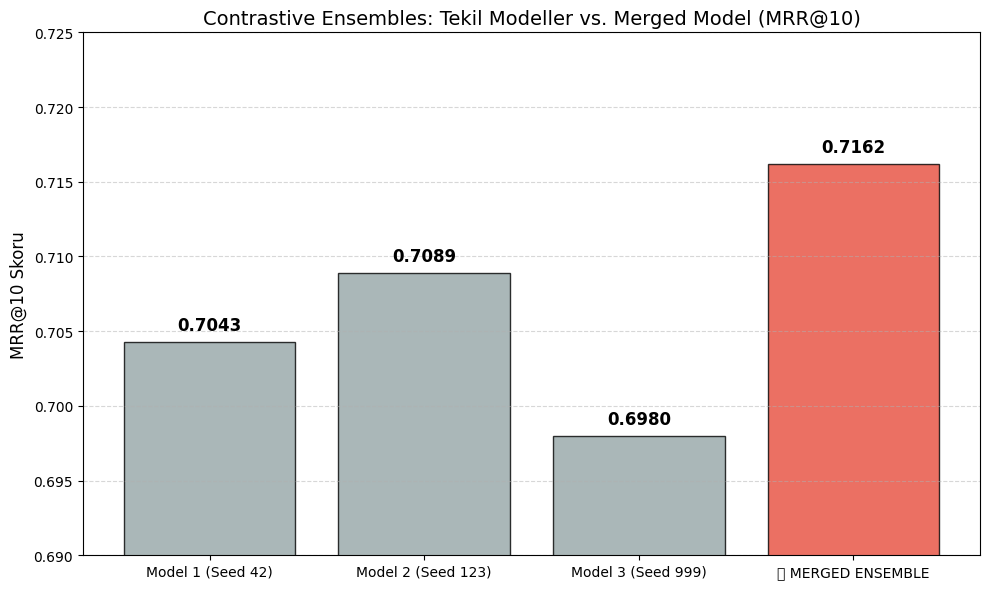

In [ ]:
# @title Sonuçları Görselleştirme (Bar Chart)
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Model 1 (Seed 42)', 'Model 2 (Seed 123)', 'Model 3 (Seed 999)', '🚀 MERGED ENSEMBLE']
mrr_scores = [0.7043, 0.7089, 0.6980, 0.7162]
colors = ['#95a5a6', '#95a5a6', '#95a5a6', '#e74c3c'] # Gri, Gri, Gri, Kırmızı (Vurgu)

plt.figure(figsize=(10, 6))
bars = plt.bar(models, mrr_scores, color=colors, edgecolor='black', alpha=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f"{yval:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0.6900, 0.7250)
plt.title('Contrastive Ensembles: Tekil Modeller vs. Merged Model (MRR@10)', fontsize=14)
plt.ylabel('MRR@10 Skoru', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()